## CycleGAN for Photo to Monet Unpaired Image translation

Kaggle Competition link: https://www.kaggle.com/competitions/gan-getting-started

### Importing required libraries

In [ ]:

# !pip install torch_snippets torch_summary --quiet
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install torch_snippets torch_summary --quiet
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import scipy
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


import random

def choose(self):
    return random.choice(self.photos)


### Unzip the data

In [ ]:
import zipfile
import os

zip_file_path = "gan-getting-started.zip"
extract_to_path = "gan-getting-started"

# Ensure the extraction directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")


### Looking at what the shape of our training and testing images

In [ ]:
#monet
from PIL import Image
import os

# Path to the directory containing JPG files
image_dir = r'gan-getting-started/monet_jpg'

# Set to store unique image sizes
unique_sizes = set()

# Iterate through all files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  # Check if the file is a JPG
        file_path = os.path.join(image_dir, filename)
        try:
            with Image.open(file_path) as img:
                # Get the image size (width, height)
                size = img.size
                unique_sizes.add(size)  # Add size to the set
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Print the unique image sizes
print("Unique image sizes:")
for size in unique_sizes:
    print(size)


Unique image sizes:
(256, 256)


In [ ]:
# photo
from PIL import Image
import os

# Path to the directory containing JPG files
image_dir = r'gan-getting-started/photo_jpg'

# Set to store unique image sizes
unique_sizes = set()

# Iterate through all files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  # Check if the file is a JPG
        file_path = os.path.join(image_dir, filename)
        try:
            with Image.open(file_path) as img:
                # Get the image size (width, height)
                size = img.size
                unique_sizes.add(size)  # Add size to the set
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Print the unique image sizes
print("Unique image sizes:")
for size in unique_sizes:
    print(size)

Unique image sizes:
(256, 256)


### Defining image transformations (augmentation)

In [ ]:
IMAGE_SIZE = 256

transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### Making our Train and Test Dataset

In [ ]:

def Glob(pattern):
    return glob(pattern + '/*.jpg')

class Monet2PhotoDataset(Dataset):
    def __init__(self, monets, photos):
        self.monets = Glob(monets)
        self.photos = Glob(photos)

    def __getitem__(self, ix):
        monet_path = self.monets[ix % len(self.monets)]
        photo_path = random.choice(self.photos)

        # Open images
        monet = Image.open(monet_path).convert('RGB')
        photo = Image.open(photo_path).convert('RGB')

        return transform(monet), transform(photo)

    def __len__(self):
        return max(len(self.monets), len(self.photos))

    def collate_fn(self, batch):
        srcs, trgs = zip(*batch)
        return torch.stack(srcs).to(device), torch.stack(trgs).to(device)

### Initializing the Data Loader

In [ ]:
trn_ds = Monet2PhotoDataset('gan-getting-started/monet_jpg', 'gan-getting-started/photo_jpg')

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)


## Defining CYCLE GAN

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

### Defining a Residual Block

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

### Generator Class

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

### Discriminator Class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

### Defining the Generator Training Step

In [ ]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

### Defining the Discriminator Training Step

In [ ]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1,  16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [ ]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

#### Define a class to handle logging and plotting of training metrics

In [ ]:
class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.logs = []
        self.current_epoch = 0
        self.start_time = time.time()

    def record(self, epoch, **kwargs):
        self.logs.append({"epoch": epoch, **kwargs})
        self.current_epoch = int(epoch)

        elapsed_time = time.time() - self.start_time

        # Handle case when current_epoch is 0
        if self.current_epoch > 0:
            remaining_time = (elapsed_time / self.current_epoch) * (self.n_epochs - self.current_epoch)
        else:
            remaining_time = 0

        print(f"EPOCH: {epoch:.3f}", end="  ")
        for key, value in kwargs.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.3f}", end="  ")
            else:
                print(f"{key}: {value}", end="  ")
        # print(f"({elapsed_time:.2f}s - {remaining_time:.2f}s remaining)", end=kwargs.get('end', '\n'))

    def report_avgs(self, epoch):
        epoch_logs = [log for log in self.logs if int(log['epoch']) == epoch]
        if not epoch_logs:
            print(f"No data available for epoch {epoch}")
            return
        avg_logs = {}
        for key in epoch_logs[0].keys():
            if key != 'epoch':
                values = [log[key] for log in epoch_logs if isinstance(log[key], (int, float))]
                if values:
                    avg_logs[key] = sum(values) / len(values)

        print(f"\nEPOCH: {epoch:.3f}", end="  ")
        for key, value in avg_logs.items():
            print(f"{key}: {value:.3f}", end="  ")
        print()

    def plot_epochs(self, metrics):
        plt.figure(figsize=(10, 6))
        for metric in metrics:
            epochs = [log['epoch'] for log in self.logs if isinstance(log.get(metric), (int, float))]
            values = [log[metric] for log in self.logs if isinstance(log.get(metric), (int, float))]
            if epochs and values:
                plt.plot(epochs, values, label=metric)

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        plt.show()

### How do we generate samples from our Cycle GAN

In [ ]:
@torch.no_grad()
def generate_sample():
    data = next(iter(trn_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

### Training the CYCLE GAN.

In [ ]:
n_epochs = 20
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

from IPython.display import clear_output
clear_output()

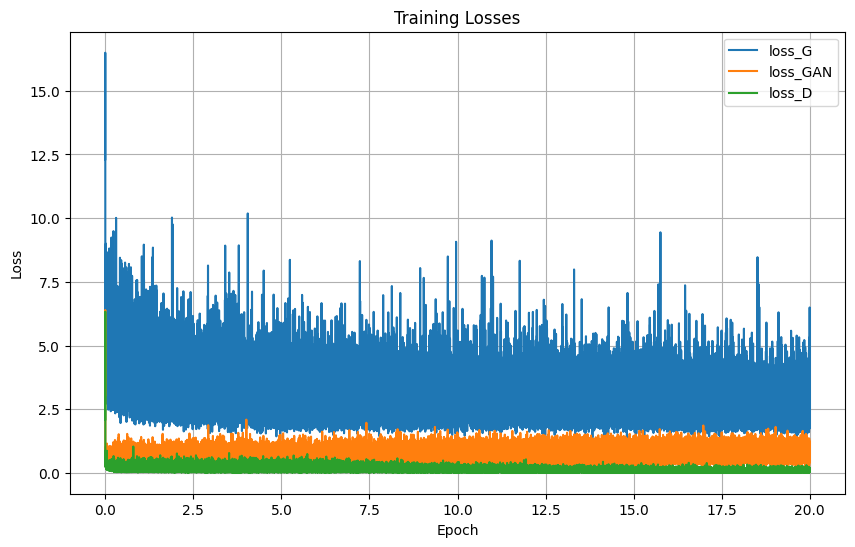

In [ ]:
log.plot_epochs(['loss_G','loss_GAN', 'loss_D'])

#### Observation from graph
Generator loss is very high compared to Discriminator loss, which is typical of GAN. We could use Wasserstein Loss to reduce the G loss and make it learn better and can also change hyperparamaters to reduce G loss and make the training more stable

#### Save the Cycle GAN model

In [ ]:

torch.save(G_AB.state_dict(), 'generator_A_to_B.pth')
torch.save(G_BA.state_dict(), 'generator_B_to_A.pth')
torch.save(D_A.state_dict(), 'discriminator_A.pth')
torch.save(D_B.state_dict(), 'discriminator_B.pth')

print("Models saved successfully.")

Models saved successfully.


#### To load the models

In [ ]:
# G_AB = GeneratorResNet().to(device)
# G_BA = GeneratorResNet().to(device)
# D_A = Discriminator().to(device)
# D_B = Discriminator().to(device)

# G_AB.load_state_dict(torch.load('generator_A_to_B.pth'))
# G_BA.load_state_dict(torch.load('generator_B_to_A.pth'))
# D_A.load_state_dict(torch.load('discriminator_A.pth'))
# D_B.load_state_dict(torch.load('discriminator_B.pth'))

# # Set models to evaluation mode
# G_AB.eval()
# G_BA.eval()
# D_A.eval()
# D_B.eval()


#### Transformation on Photo - Monet

In [ ]:
def transform_image(image_path, generator, direction='AB'):
    # Load the image
    img = Image.open(image_path).convert('RGB')

    # Define the same transformation as used in training
    transform = transforms.Compose([
        transforms.Resize(int(256*1.33)),
        # transforms.RandomCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Apply the transformation
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Generate the transformed image
    generator.eval()
    with torch.no_grad():
        if direction == 'AB':
            fake_img = generator(img_tensor)
        else:  # 'BA'
            fake_img = generator(img_tensor)

    # Convert the tensor to a displayable image
    fake_img = (fake_img.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2
    fake_img = (fake_img * 255).clip(0, 255).astype('uint8')

    # Display the original and transformed images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(fake_img)
    ax2.set_title('Transformed Image')
    ax2.axis('off')
    plt.show()

    return fake_img

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to transform and save the generated images
def transform_and_save_images(image_paths, generator, output_dir, direction='AB'):

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define the same transformation as used in training
    transform = transforms.Compose([
        transforms.Resize(int(256 * 1.33)),  # Resize with scaling
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Set the generator to evaluation mode
    generator.eval()

    for image_path in image_paths:
        # Load and preprocess the image

        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Transform the image
        with torch.no_grad():
            if direction == 'AB':
                fake_img = generator(img_tensor)
            else:  # 'BA'
                fake_img = generator(img_tensor)

        # Convert the tensor to a PIL image for saving
        fake_img = (fake_img.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2
        fake_img = (fake_img * 255).clip(0, 255).astype('uint8')
        fake_img_pil = Image.fromarray(fake_img)

        # Generate the output file path and save the image
        file_name = os.path.basename(image_path)
        output_path = os.path.join(output_dir, f"monet_{file_name}")
        fake_img_pil.save(output_path)

    print(f"Transformed photo images are saved to {output_dir}")

In [ ]:
import glob

# Collect all image paths from the input directory
input_dir = 'gan-getting-started/photo_jpg/'
image_paths = glob.glob(f"{input_dir}*.jpg")  # Collect all .jpg files in the directory

# Call the function with the correct list of image paths
transform_and_save_images(
    image_paths=image_paths,
    generator=G_BA,
    output_dir='gan-getting-started/output/monet_output_jpg',
    direction='BA'
)

transform_and_save_images('gan-getting-started/photo_jpg', G_BA, 'gan-getting-started/output/monet_output_jpg', direction='BA')

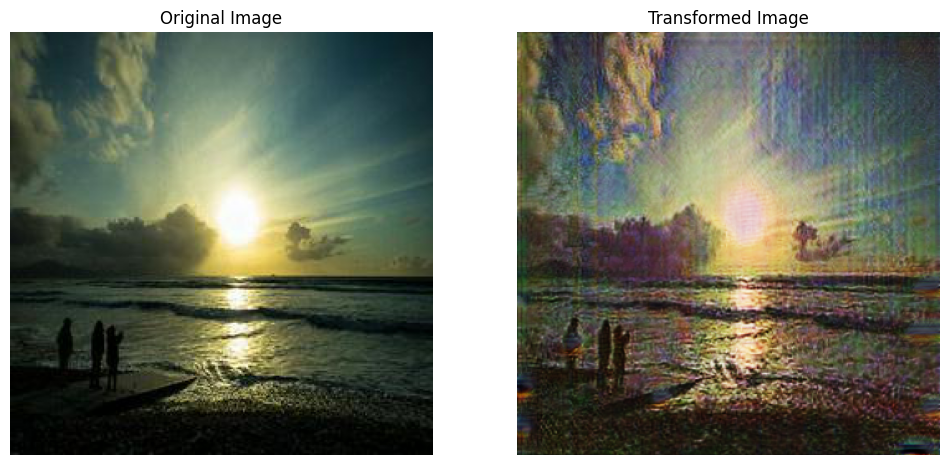

In [ ]:
transformed_img_1 = transform_image('gan-getting-started/photo_jpg/000ded5c41.jpg', G_BA, direction='BA')

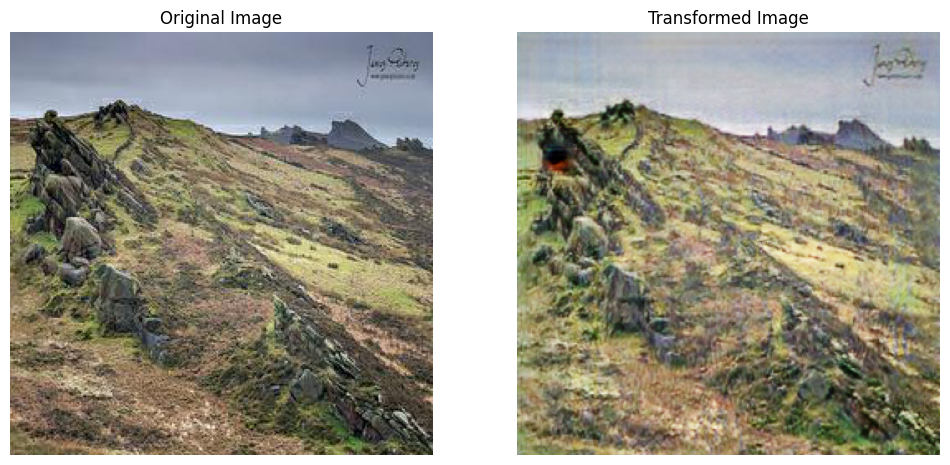

In [ ]:
transformed_img_2 = transform_image('gan-getting-started/photo_jpg/1b3e398db7.jpg', G_BA, direction='BA')

#### Observations
* in both photo to monet image transformations above, we see that the Monet style 'Imperssionism' is observed in both translations but some finer details are lost.


In [ ]:
import glob

# Collect all image paths from the input directory
input_dir = 'gan-getting-started/photo_jpg/'

output_dir = 'gan-getting-started/output/monet_output_jpg'
output_image_paths = glob.glob(f"{output_dir}/*.jpg")
# Paths to real and generated images
real_image_paths = image_paths
generated_image_paths = output_image_paths

In [ ]:


def load_images(image_paths, transform=None):

    images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            if transform:
                img = transform(img)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return torch.stack(images)

def calculate_activations(images, model):

    model.eval()
    with torch.no_grad():
        activations = model(images)
    return activations.cpu().numpy()

def calculate_mifid(real_image_paths, generated_image_paths, batch_size=32):

    # Prepare InceptionV3 model
    inception = models.inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove the classification layer
    inception.eval()

  # Define the same transformation as used in training
    transform = transforms.Compose([
        transforms.Resize(int(256 * 1.33)),  # Resize with scaling
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    real_image_paths = real_image_paths
    generated_image_paths = generated_image_paths

    # Load and process real images in batches
    real_activations = []
    for i in range(0, len(real_image_paths), batch_size):
        batch_paths = real_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        real_activations.append(calculate_activations(batch_images, inception))
    real_activations = np.concatenate(real_activations, axis=0)

    # Load and process generated images in batches
    generated_activations = []
    for i in range(0, len(generated_image_paths), batch_size):
        batch_paths = generated_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        generated_activations.append(calculate_activations(batch_images, inception))
    generated_activations = np.concatenate(generated_activations, axis=0)

    # Calculate mean and covariance
    real_mu = np.mean(real_activations, axis=0)
    generated_mu = np.mean(generated_activations, axis=0)

    real_sigma = np.cov(real_activations, rowvar=False)
    generated_sigma = np.cov(generated_activations, rowvar=False)

    # Compute FID
    diff = real_mu - generated_mu
    covmean, _ = scipy.linalg.sqrtm(real_sigma.dot(generated_sigma), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(real_sigma + generated_sigma - 2 * covmean)

    # Compute scaling factor for MiFID
    scale = math.sqrt(len(real_image_paths) / len(generated_image_paths))
    mifid = fid * scale
    print(scale)
    return fid, mifid

fid_score, mifid_score = calculate_mifid(real_image_paths, generated_image_paths)
print(f"FID Score: {fid_score}")
print(f"MiFID Score: {mifid_score}")

1.0
FID Score: 23.752519533617622
MiFID Score: 23.752519533617622
